In [1]:
#below classes we used to interact with any llm model
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langchain_huggingface import ChatHuggingFace,HuggingFaceEndpoint

#to convert the simple user query to Prompt we are using Chatprompttemplate,prompttemplate
from langchain_core.prompts import PromptTemplate,ChatPromptTemplate

#parser classes to parser 
from langchain_core.output_parsers import StrOutputParser,PydanticOutputParser

#loading the env filter
from dotenv import load_dotenv

from langchain_core.messages import ToolMessage,AIMessage,HumanMessage,SystemMessage

load_dotenv()

True

In [2]:
#creating an object of chatGroq class
model1 = ChatGroq(
    model="llama-3.1-8b-instant",temperature=0 #temperature is called creative parameter
)

#creating an object openai model class
model2 = ChatOpenAI(
    model="gpt-3.5-turbo",temperature=0
)

#creating an object open source model.
#HuggingFaceEndpoint is a class where we are sending or hitting user query request to get response
llm = HuggingFaceEndpoint(  
        repo_id="meta-llama/Meta-Llama-3-8B-Instruct",  
        task="text-generation",  
        )  
model3 = ChatHuggingFace(llm=llm)

# creating tools that can be used in chatBot

In [3]:
from langchain_core.tools import Tool,tool
#using tavily searching tool.
from langchain_tavily import TavilySearch

search_tool = TavilySearch(
    max_results=2,
    topic="general",)



# Calculator tool
def calculator(first_num: float, second_num: float, operation: str) -> dict:
    try:
        if operation == "add": result = first_num + second_num
        elif operation == "sub": result = first_num - second_num
        elif operation == "mul": result = first_num * second_num
        elif operation == "div": result = first_num / second_num if second_num != 0 else "Division by zero"
        else: return {"error": f"Unsupported operation {operation}"}
        return {"first_num": first_num, "second_num": second_num, "operation": operation, "result": result}
    except Exception as e:
        return {"error": str(e)}

calc_tool = Tool(
    name="Calculator",
    func=calculator,
    description="Perform basic arithmetic: add, sub, mul, div"
)

# Stock price tool
import requests
def get_stock_price(symbol: str) -> dict:
    url = f'https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol={symbol}&apikey=1PPNPDOMK62HNKRO'
    return requests.get(url).json()

stock_tool = Tool(
    name="StockPrice",
    func=get_stock_price,
    description="Fetch latest stock price for a given symbol"
)

In [4]:
#binding the tools with llm
lst_tools = [search_tool,stock_tool,calc_tool]
llm_with_tool = model2.bind_tools(lst_tools)
llm_with_tool

RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x0000021512FC1240>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x0000021512FF02B0>, root_client=<openai.OpenAI object at 0x0000021512FC19C0>, root_async_client=<openai.AsyncOpenAI object at 0x00000215143C4F40>, temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type':

# building the workflow

In [5]:
#define the state schema. we can used any of two classes
from langchain_core.messages import AnyMessage
from langgraph.graph.message import BaseMessage
from typing import Annotated,TypedDict
from langgraph.graph import StateGraph

from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages] 
    #add_messgae is reducer will perform adding/concatenation operation of msg generated by LLM
    
graph = StateGraph(state_schema=MessagesState)

### We use the built-in ToolNode and simply pass a list of our tools to initialize it nodes of tools in worklfow.

### We use the built-in tools_condition as our conditional edge.

In [ ]:
def tool_calling_llm(state:MessagesState) ->MessagesState:
    #fetching the message from state.
    messages = state['messages']
    
    #sending this msg to llm model
    response = llm_with_tool.invoke(messages) #yaha pe llm decide karta hai query solve karne tool use hoga llm generic response dey
    
    #return this response to state or updating it.
    return {
        "messages":[response] #passing entire AI reponse to state memory in alist format
    }
    
    
#creating tool node by using predefined class of toolnode.
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition



tool_calling_node = ToolNode(tools=lst_tools)

In [7]:
from langgraph.graph import START,END
#building nodes and edges
graph.add_node(node="tool_calling_llm",action=tool_calling_llm)

graph.add_node(node="tools",action=tool_calling_node)

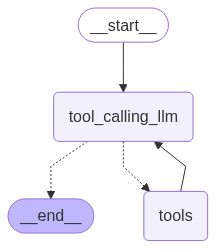

In [8]:
#adding edges to graph.
graph.add_edge(START,"tool_calling_llm")
graph.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
graph.add_edge("tools", "tool_calling_llm")

graph.compile()

In [10]:
workflow = graph.compile()
from langchain_core.messages import HumanMessage


messages = [HumanMessage(content="capital of china country")]

##initial state passing to my worklfow
messages = workflow.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

capital of china country
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_ks7CegbuZej6Bgrq4NfKJGRX)
 Call ID: call_ks7CegbuZej6Bgrq4NfKJGRX
  Args:
    query: capital of China country
    search_depth: basic
================================= Tool Message =================================
Name: tavily_search

{"query": "capital of China country", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://en.wikipedia.org/wiki/China", "title": "China - Wikipedia", "content": "Beijing is the country's capital, while Shanghai is its most populous city by urban area and largest financial center. People's Republic of China. 中华人民", "score": 0.85216236, "raw_content": null}, {"url": "https://clintonwhitehouse3.archives.gov/WH/New/China/beijing.html", "title": "Beijing - The White House", "content": "The modern day capit

In [11]:
messages = [HumanMessage(content="stock price of tesla")]

##initial state passing to my worklfow
messages = workflow.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

stock price of tesla
================================== Ai Message ==================================
Tool Calls:
  StockPrice (call_OLC27ICyox2jyX9xUYiD912j)
 Call ID: call_OLC27ICyox2jyX9xUYiD912j
  Args:
    __arg1: TSLA
================================= Tool Message =================================
Name: StockPrice

{"Global Quote": {"01. symbol": "TSLA", "02. open": "423.1300", "03. high": "425.7000", "04. low": "402.4300", "05. price": "410.0400", "06. volume": "163823667", "07. latest trading day": "2025-09-15", "08. previous close": "395.9400", "09. change": "14.1000", "10. change percent": "3.5611%"}}
================================== Ai Message ==================================

The current stock price of Tesla (TSLA) is $410.04. The stock opened at $423.13, with a high of $425.70 and a low of $402.43. The previous close was $395.94, and there has been a change of $14.10 (3.56%) since the pre

In [12]:
messages = [HumanMessage(content="what is 2 * 3?")]

##initial state passing to my worklfow
messages = workflow.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

what is 2 * 3?
================================== Ai Message ==================================
Tool Calls:
  Calculator (call_ulgFxEepDhgf5cGLkb0FPHGK)
 Call ID: call_ulgFxEepDhgf5cGLkb0FPHGK
  Args:
    __arg1: 2 * 3
================================= Tool Message =================================
Name: Calculator

Error: TypeError("calculator() missing 2 required positional arguments: 'second_num' and 'operation'")
 Please fix your mistakes.
================================== Ai Message ==================================
Tool Calls:
  Calculator (call_8thcrWbKvpqrP66uXJuwboA0)
 Call ID: call_8thcrWbKvpqrP66uXJuwboA0
  Args:
    __arg1: 2*3
================================= Tool Message =================================
Name: Calculator

Error: TypeError("calculator() missing 2 required positional arguments: 'second_num' and 'operation'")
 Please fix your mistakes.
================================== Ai M

In [13]:
messages = [HumanMessage(content="hello llm")]

##initial state passing to my worklfow
messages = workflow.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

hello llm
================================== Ai Message ==================================

Hello! How can I assist you today?


In [16]:
messages = [HumanMessage(content="stock price of apple")]
response = workflow.invoke({"messages": messages})
response

{'messages': [HumanMessage(content='stock price of apple', additional_kwargs={}, response_metadata={}, id='665cfb6e-ca7a-4eba-870d-feb4f8305aec'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_AJCjhSPJC01yGo6oMgEJixL0', 'function': {'arguments': '{"__arg1":"AAPL"}', 'name': 'StockPrice'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 1404, 'total_tokens': 1422, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-CGPp1DGnmkf2dQY2VkgTVs3fkRUsS', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--f048782b-0bae-4824-a0c6-6e5840498d2c-0', tool_calls=[{'name': 'StockPrice', 'args': {'__arg1': 'AAPL'}, 'id': 'call_AJCjhSPJC01yGo6oMgEJ

### sending back Tool Message to get refined result show in output

In [18]:
messages = [HumanMessage(content="if i buy  4 apple stocks how much it cost")]
response = workflow.invoke({"messages": messages})

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

if i buy  4 apple stocks how much it cost
================================== Ai Message ==================================
Tool Calls:
  StockPrice (call_dCyyaAECuMcXsRHHa9DVXASv)
 Call ID: call_dCyyaAECuMcXsRHHa9DVXASv
  Args:
    __arg1: AAPL
================================= Tool Message =================================
Name: StockPrice

{"Global Quote": {"01. symbol": "AAPL", "02. open": "237.0000", "03. high": "238.1900", "04. low": "235.0300", "05. price": "236.7000", "06. volume": "42699524", "07. latest trading day": "2025-09-15", "08. previous close": "234.0700", "09. change": "2.6300", "10. change percent": "1.1236%"}}
================================== Ai Message ==================================

The current price of one Apple (AAPL) stock is $236.70. 

If you buy 4 Apple stocks, the total cost would be $946.80 (4 stocks x $236.70).
